In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import random
import pathlib
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import uuid
import cv2
import os
import shutil
import albumentations as A
import tensorflow as tf
from tensorflow.keras.models import model_from_json
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import dash
# from dash import dcc, html
# from dash.dependencies import Input, Output
from matplotlib import pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import metrics as metrics


metrics=[ tf.metrics.CategoricalAccuracy(name="acc"),
      tf.keras.losses.CategoricalCrossentropy(name='loss'),
      tf.keras.metrics.F1Score(average="macro", threshold=None, name='f1_score'),
      tf.metrics.Precision(name='precision'),
      tf.metrics.Recall(name='recall')]

train_paths=r"/kaggle/input/train-val-plant/train/content/drive/MyDrive/ColabNotebooks/Datas/Plantvilage_that_we_will_use"
val_paths=r"/kaggle/input/train-val-plant/val/content/drive/MyDrive/ColabNotebooks/Datas/V_plant"
test_paths=r"/kaggle/input/train-val-plant/test/content/drive/MyDrive/ColabNotebooks/Datas/T_plant"

In [7]:
!nvidia-smi
device_name = tf.test.gpu_device_name()

print('Found GPU at: {}'.format(device_name))

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

tf.__version__

Sat May 24 20:01:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             31W /  250W |     259MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

I0000 00:00:1748116886.498502      35 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


'2.18.0'

In [27]:
def extract_plant_names(folder_names, pattern):
    """
    Extract plant names from folder names using a regex pattern.
    Alerts for any unmatched folder names.

    Parameters:
        folder_names (list): List of folder names to process.
        pattern (str): Regex pattern to extract plant names.

    Returns:
        plant_names (list): List of extracted plant names.
        sub_names (list): List of the folder names with out the plant string.
    """
    plant_names = []
    unmatched = []
    sd_names = []

    for folder in folder_names:
        match = re.match(pattern, folder)
        if match:
            plant_name = match.group(1)
            sd_name = folder.split("___")[1]  # Assuming "___" separates the plant and the second name
            plant_names.append(plant_name)
            sd_names.append(sd_name)
        else:
            plant_names.append("Unknown")
            sd_names.append("Unknown")
            unmatched.append(plant_names)

    # Alert for unmatched folder names
    if unmatched:
        print("⚠️ Alert: The following folder names did not match the expected pattern:")
        for folder in unmatched:
            print(f"- {folder}")

    return plant_names,sd_names


def classify_folders(counts):
    """
    Categorizes numerical counts into:
      - 'Above_mean' (counts => mean)
      - 'Below_mean' (half_mean ≤ counts ≤ mean)
      - 'Risk' (counts < half_mean)

    Returns a NumPy array of category labels.
    """
    mean_value = int(counts.mean())
    half_mean = mean_value // 2  # Ensure integer division consistency


    print(f"Mean: {mean_value}, Half Mean: {half_mean}")

    return np.select(
        [counts >= mean_value, counts >= half_mean],
        ["Above_mean", "Below_mean"],
        default="Risk"
    )


def meta_data(folder_counts):
  mean_value = int(folder_counts["Counts"].mean())

  # Anything that is" not in Risk will have 100 items the rest will be 200 items for validation and test
  folder_counts["split_size"] = np.where(folder_counts["MeanCategory"] != "Risk", 200, 100)

  # Compute the number of images available for training after the split
  folder_counts["train_files"] = folder_counts["Counts"] - (folder_counts["split_size"]*2)
  # we cut down the Above_mean category
  folder_counts.loc[folder_counts["MeanCategory"] == "Above_mean", "train_files"] = mean_value // 2

  # Compute the number of images that we need to compensate with augmentation
  folder_counts["Augment_Needed"] = np.maximum(0, mean_value - folder_counts["train_files"])

  # Compute the number of distinct images required for augmentation (rounded up)
  folder_counts["original_files"] = np.ceil(folder_counts["Augment_Needed"] / 15).astype(int)
  return folder_counts

def parse_root(root,pattern = r'^([^_]+)',remove=None):
    """Parse dataset folder structure and build a dataframe with metadata."""


    p = pathlib.Path(root)
    dist_files = {
        folder.name: [file for file in folder.iterdir()]
        for folder in p.iterdir() if folder.is_dir()
    }
    # Count files in each folder
    folder_counts = pd.DataFrame({
        'Folder': dist_files.keys(),
        'Counts': [len(v) for v in dist_files.values()]
    })

    if remove is None:
      remove=['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Tomato___Tomato_Yellow_Leaf_Curl_Virus',
        'Apple___Cedar_Rust','Tomato___Tomato_mosaic_virus','Potato___Early_blight','Potato___Late_blight','Potato___healthy',"Soybean___healthy","Blueberry___healthy","Orange___Haunglongbing_(Citrus_greening)","Raspberry___healthy","Squash___Powdery_mildew"]
      folder_counts.drop(folder_counts[folder_counts['Folder'].isin(remove)].index,inplace=True)
    # fldoer_counts = folder_counts.drop(columns=[key for key in remove if key in folder_counts])
      folder_counts.reset_index(drop=True, inplace=True)

    folder_counts['Plants'], folder_counts['Sub'] = extract_plant_names(folder_counts['Folder'],pattern)
    folder_counts['MeanCategory'] = classify_folders(folder_counts['Counts'])
    folder_counts = meta_data(folder_counts)

    return folder_counts, dist_files


def distribute_data(df, dist_files):

  """" Creates splits of train,validation and iamge file paths and take some to be augmented.
      Based on the metadata we transform the split strategy and provide sets of files to be used.

  """

  train, validation, test, aug_train = {}, {}, {}, {}
  for _, row in df.iterrows():
    folder = row["Folder"]
    available_files = dist_files.get(folder, []).copy()

    # Shuffle to ensure randomness
    random.shuffle(available_files)

    # Extract necessary values
    split_size = row["split_size"]  # Now dynamically assigned per category
    distinct_aug_sources = int(row["original_files"])  # Available distinct images
    # For each key : Folder Name

    # 1) Allocate test set
    test[folder], available_files = available_files[:split_size], available_files[split_size:]

    # 2) Allocate validation set
    validation[folder], available_files = available_files[:split_size], available_files[split_size:]

    # 3) Reserve originals for augmentation (only if augment=True)
    aug_train[folder], available_files = available_files[:distinct_aug_sources], available_files[distinct_aug_sources:]

    train[folder] = available_files

  return train, validation, test, aug_train


def describe_model(models):
    """
    Recursively gather layers info from a final model, *but*:
      - For the base model (like MobileNetV2), retrieve the base model name as a string in a separate column.
        (No expansion of base layers)
      - For the 'head' model (e.g., a Sequential), skip the top-level name, but store each sub-layer
        (Dense/Dropout, etc.).

    Returns a list of tuples: (model_label, layer_name, attribute_value, base_model_string).
    """

    if isinstance(models, tf.keras.Model):
        models = [models]

    all_info = []

    def store_info(label, layer_obj, base_model_str=None):
        """
        Extract attribute from layer_obj (units, filters, rate) if present.
        Return a tuple (label, layer_name, attr_val, base_model_str).
        """
        if hasattr(layer_obj, 'units'):
            attr_val = layer_obj.units
        elif hasattr(layer_obj, 'filters'):
            attr_val = layer_obj.filters
        elif hasattr(layer_obj, 'rate'):
            attr_val = layer_obj.rate
        else:
            attr_val = None

        return (label, layer_obj.name, attr_val, base_model_str)

    def is_base_model(layer):
        """
        Heuristic check: if layer is a Keras Model and it's one of the known
        pretrained application names or typically has 'mobilenetv2', 'resnet50', etc. in the name,
        we treat it as the 'base model.'
        """
        if isinstance(layer, tf.keras.Model):
            if any(k.lower() in layer.name.lower() for k in ["mobilenetv2", "resnet50","EfficientNetB0"]):
                return True
        return False

    def expand_layers(layer_list, parent_label="", base_model_str=None):
        """
        For each layer in layer_list:
          - If it's the 'base model', remember its name for all following layers.
          - If it's a sub-model (not base), expand it recursively.
          - Otherwise, store the layer info including base_model_str.
        """
        for layer in layer_list:
            if is_base_model(layer):
                base_model_str = layer.name
            elif isinstance(layer, tf.keras.Model):
                expand_layers(layer.layers, parent_label=parent_label, base_model_str=base_model_str)
            else:
                info = store_info(parent_label, layer, base_model_str)
                all_info.append(info)

    for model_obj in models:
        expand_layers(model_obj.layers, parent_label=model_obj.name)

    return layer_info_to_df(all_info)


def layer_info_to_df(layer_info):
    """
    layer_info : list of tuples [(model_label, layer_name, attr_val, base_model_string), ...]
    Returns a DataFrame with columns: [model name, layer name, score, base model]
    """
    df = pd.DataFrame(layer_info, columns=["model name", "layer name", "score", "base model"])

    # Clean trailing digits from layer names (optional)
    df['layer name']=df['layer name'].apply(lambda x: re.sub(r'_.*', '', x))

    # Generate unique label where layer name is not null

    df['label'] = (
        df.groupby(['model name', 'layer name'])
        .cumcount()
        .astype(str)
        .radd(df['layer name'] + '_'))

    df.dropna(inplace=True)

    return df




In [5]:

weather = A.Compose([
     A.RandomSnow(brightness_coeff=1.7,  snow_point_range= (0.3,0.5),p=0.5),
     A.RandomRain(brightness_coefficient=0.8, drop_width=2, blur_value=3, p=0.5)
 ])

light = A.Compose([
    # A. RandomBrightnessContrast(brightness_limit=(-0.23,0.35),p=0.5),
    A.GridDropout(ratio=0.3,p=0.5),
    A.MultiplicativeNoise(multiplier=(0.97,2.30),elementwise=True,per_channel=True,p=0.5)
])

geometric = A.Compose([
     A.CLAHE(p=1),
     A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5)

])

def Aug(img_path,loops):
    """
    Load one image with Keras, then produce 16 images:
      1 original + 15 augmented (5 loops × 3 pipelines).
    Each returned image is np.uint8 in [0..255].
    Shape is consistent with the original loaded image.
    """
    pil_img = tf.keras.utils.load_img(img_path, color_mode='rgb')
    base_arr = np.array(pil_img, dtype=np.uint8)

    aug_list = [base_arr]  # keep original
    sshape = base_arr.shape  # (H, W, 3)

    for _ in range(loops):
        w = weather(image=base_arr)['image']
        l = light(image=base_arr)['image']
        g = geometric(image=base_arr)['image']
        for arr in [w, l, g]:
            if arr.shape != sshape:
                arr = np.resize(arr, sshape)
            aug_list.append(arr)

    return aug_list


def build_dataset_from_dict(
    data_dict,
    target_size= None,
    to_augment= None,
    loops= 5) -> tf.data.Dataset:


    def parse_record(file_path, label_str):
        """
        - file_path: tf.string path to the image file
        - label_str: tf.string label
        """
        # Read file from disk
        image_bytes = tf.io.read_file(file_path)

        # Decode image (handles PNG, JPEG, etc.), expand_animations=False ensures a single image
        img = tf.io.decode_image(image_bytes, channels=3)
        # Now img has shape [height, width, 3], dtype=uint8 in [0..255]

        # Convert to float [0..1], then resize
        img = tf.image.convert_image_dtype(img, tf.float32)
        img.set_shape([None, None, 3])
        if target_size is not None:
          img = tf.image.resize(img, target_size)  # (H, W, 3)
        return img, label_str


     #  make (file_path, label)  Flatten dict -> (files, labels)
    def flatten_dict(d):
        # Create two parallel lists
        file_paths = []
        labels = []
        for lbl, paths in d.items():
            for p in paths:
                file_paths.append(str(p))
                labels.append(lbl)
        return file_paths, labels

    normal_files, normal_labels = flatten_dict(data_dict)
    # 2) Create dataset from these records and process it
    ds = tf.data.Dataset.from_tensor_slices((normal_files,normal_labels))
    ds = ds.map(parse_record, num_parallel_calls=tf.data.AUTOTUNE)

    if not to_augment:
        return ds

    # -- streaming generator for AUGMENTED images -------------
    def gen():
        for lbl, paths in to_augment.items():
            for p in paths:
                for arr in Aug(p, loops=loops):
                    yield arr, lbl

    ds_aug = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(),              dtype=tf.string),
        ))


    # scale uint8→float32, resize
    def scale_uint8(img_u8, label):
        img = tf.image.convert_image_dtype(img_u8, tf.float32)
        img.set_shape([None, None, 3])
        label = tf.cast(label, tf.string)
        if target_size is not None:
          img = tf.image.resize(img, target_size)  # (H, W, 3)
        return img, label

    ds_aug = ds_aug.map(scale_uint8, num_parallel_calls=tf.data.AUTOTUNE)

    # -- merge & return --------------------------------------
    ds_final=ds.concatenate(ds_aug)
    return ds_final



In [8]:
# df,dist=parse_root('/kaggle/input/plantvillage-dataset/color')
# print(df.head())
# train,val,test,aug=distribute_data(df, dist)
size=224
BATCH=256
df=parse_root('/kaggle/input/plantvillage-dataset/color')
train_data = tf.keras.utils.image_dataset_from_directory(train_paths,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             batch_size=BATCH,
                                             seed = 42,
                                             image_size=(size,size))

validation_data = tf.keras.utils.image_dataset_from_directory(val_paths,
                                             shuffle=False,
                                             label_mode = 'categorical',
                                             batch_size=BATCH,
                                             image_size=(size,size))

test_data = tf.keras.utils.image_dataset_from_directory(test_paths,
                                             shuffle=False,
                                             label_mode = 'categorical',
                                             batch_size=BATCH,
                                             image_size=(size,size))


# print(f"Train size: {len(train)} and {sum(len(v) for v in train.values())}")
# print(f"Augmented: {len(aug)} and {sum(len(v) for v in aug.values())}")
# print(f"Validation size: {len(val)} and {sum(len(v) for v in val.values())}")
# print(f"Test size: {len(test)} and {sum(len(v) for v in test.values())}")


Mean: 1170, Half Mean: 585
Found 32833 files belonging to 26 classes.
Found 4900 files belonging to 26 classes.
Found 4900 files belonging to 26 classes.


In [8]:

# n=df["Folder"].to_list()
# train_dataset=build_dataset_from_dict(data_dict=train,to_augment=aug)
# print("Element spec:", train_dataset.element_spec)

# for imgs, lbls in train_dataset.take(1):
#     print("Batch image tensor shape:", imgs.shape)   # (batch, 224, 224, 3)
#     print("Batch labels:", lbls.numpy())




# string_lookup = tf.keras.layers.StringLookup(
#                     vocabulary      = n,
#                     output_mode     = "one_hot",
#                     num_oov_indices = 0)

# train_dataset= train_dataset.map(
#     lambda img, lbl: (
#         img,
#         tf.squeeze(                      # remove length‑1 middle axis
#             tf.cast(string_lookup(lbl), tf.float32),
#             axis=-2                      # or axis=1 (same thing here)
#         )
#     ),
#     num_parallel_calls=tf.data.AUTOTUNE
# )


# train_dataset = (train_dataset
#                   .shuffle(1024)
#                   .batch(BATCH)
#                   .prefetch(tf.data.AUTOTUNE))

# val_dataset=build_dataset_from_dict(data_dict=val)
# val_dataset= val_dataset.map(
#     lambda img, lbl: (
#         img,
#         tf.squeeze(                      # remove length‑1 middle axis
#             tf.cast(string_lookup(lbl), tf.float32),
#             axis=-2                      # or axis=1 (same thing here)
#         )
#     ),
#     num_parallel_calls=tf.data.AUTOTUNE
# )

# val_dataset = (val_dataset
#                   .batch(BATCH)
#                   .prefetch(tf.data.AUTOTUNE))

Element spec: (TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))
Batch image tensor shape: (256, 256, 3)
Batch labels: b'Tomato___Late_blight'


In [9]:
def build_models(head_fns, input_shape=(224,224,3),num_classes=26,name=None):
    model_dict = {
            "MobileNetV2": {
                "application": tf.keras.applications.MobileNetV2,
                "preprocess": tf.keras.applications.mobilenet_v2.preprocess_input
            },
            "ResNet50": {
                "application": tf.keras.applications.ResNet50,
                "preprocess": tf.keras.applications.resnet50.preprocess_input
            },
            "EfficientNetB0": {
                "application": tf.keras.applications.EfficientNetB0,
                "preprocess": tf.keras.applications.efficientnet.preprocess_input
            },
            "ResNetv2":{
                "application": tf.keras.applications.ResNet50V2,
                "preprocess": tf.keras.applications.resnet_v2.preprocess_input
            }}
    models=[]
    if name is not None:
        
        model_config = model_dict[name]
        application = model_config["application"]
        preprocess = model_config["preprocess"]
        
        inputs = tf.keras.Input(shape=input_shape)
        x = preprocess(inputs)
        base_model = application(input_shape=input_shape, include_top=False, weights='imagenet')
        base_model.trainable = False  # Make the base model non-trainable
        x = base_model(x, training=False)
        for head_fn in head_fns:
            outputs = head_fn(x, num_classes)
            model = tf.keras.Model(inputs, outputs, name=f"{base_model}_{head_fn.__name__}")
            models.append(model)
        return models
        
    elif name is None: 
        for i in model_dict.keys():
        # load the the responsible layers from the defined dictionary
            model_config = model_dict[i]
            application = model_config["application"]
            preprocess = model_config["preprocess"]

            inputs = tf.keras.Input(shape=input_shape)
            x = preprocess(inputs)
            base_model = application(input_shape=input_shape, include_top=False, weights='imagenet')
            base_model.trainable = False  # Make the base model non-trainable
            x = base_model(x, training=False)
            for head_fn in head_fns:
                outputs = head_fn(x, num_classes)
                model = tf.keras.Model(inputs, outputs, name=f"{i}_{head_fn.__name__}")
                models.append(model)
    return models
  

def head_b_256_128_64(x, num_classes):
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return tf.keras.layers.Dense(num_classes, activation='softmax')(x)

def head_256_128_64(x, num_classes):
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return tf.keras.layers.Dense(num_classes, activation='softmax')(x)

def head_b_256_d(x,num_classes):
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    return tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
head_fn=[head_b_256_d]

models=build_models(head_fns=head_fn,num_classes=26)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
models

[<Functional name=MobileNetV2_head_b_256_d, built=True>,
 <Functional name=ResNet50_head_b_256_d, built=True>,
 <Functional name=EfficientNetB0_head_b_256_d, built=True>,
 <Functional name=ResNetv2_head_b_256_d, built=True>]

In [14]:
base_learning_rate=0.0001
for model in models:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                    loss=tf.keras.losses.CategoricalCrossentropy(name='loss'),
                    metrics=metrics)
    print(model.summary(),sep="\n")


Model: "MobileNetV2_head_b_256_d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,597,722 (9.91 MB)

 Trainable params: 337,178 (1.29 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

None


Model: "ResNet50_head_b_256_d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 2048)           │          8,192 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        524,544 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 26)             │          6,682 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,127,130 (92.04 MB)

 Trainable params: 535,322 (2.04 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

None


Model: "EfficientNetB0_head_b_256_d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,389,309 (16.74 MB)

 Trainable params: 337,178 (1.29 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

None


Model: "ResNetv2_head_b_256_d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_1 (Subtract)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,104,218 (91.95 MB)

 Trainable params: 535,322 (2.04 MB)

 Non-trainable params: 23,568,896 (89.91 MB)

None


In [28]:
df=describe_model(models)
df

,model name,layer name,score,base model,label
3,MobileNetV2_head_b_256_d,dense,256.0,mobilenetv2_1.00_224,dense_0
4,MobileNetV2_head_b_256_d,dropout,0.5,mobilenetv2_1.00_224,dropout_0
5,MobileNetV2_head_b_256_d,dense,26.0,mobilenetv2_1.00_224,dense_1
9,ResNet50_head_b_256_d,dense,256.0,resnet50,dense_0
10,ResNet50_head_b_256_d,dropout,0.5,resnet50,dropout_0
11,ResNet50_head_b_256_d,dense,26.0,resnet50,dense_1
15,EfficientNetB0_head_b_256_d,dense,256.0,efficientnetb0,dense_0
16,EfficientNetB0_head_b_256_d,dropout,0.5,efficientnetb0,dropout_0
17,EfficientNetB0_head_b_256_d,dense,26.0,efficientnetb0,dense_1
21,ResNetv2_head_b_256_d,dense,256.0,resnet50v2,dense_0


In [16]:
import datetime
# path='/content/drive/MyDrive/ColabNotebooks/Final_thesis_code/app/'

def Call_meback(save_weights=False,save_metrics=True,stop_early=True,path=None,patience=2,file_name=None,name="model",plot=False):
  if file_name is None :
        file_name = "This_is_epoch={epoch:02d}_loss={val_loss:.2f}_f1={val_f1_score:.2f}.keras"
  if path is None: path = "/kaggle/working/store"
  #time
  time = datetime.datetime.now().strftime("_%d-%m-%y->%H:%m")
  #Given or generic name
  model_dir = os.path.join(path,time,name)
  os.makedirs(model_dir, exist_ok=True)
  # END to END filepath
  filep=os.path.join(model_dir,file_name)
  temp=[]



  if save_metrics == True:
    csv=tf.keras.callbacks.CSVLogger(os.path.join(model_dir,'Logs.csv'), separator=",")
    temp.append(csv)
  if stop_early == True:
    stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience,verbose=1)
    temp.append(stop)
  if save_weights == True:
    h5=tf.keras.callbacks.ModelCheckpoint(filepath=filep,
                                          monitor='val_loss',
                                          save_weights_only=False,
                                          save_best_only=True,
                                          initial_value_threshold=0.50,
                                          verbose=1)
    temp.append(h5)
  # elif plot is True: print(ToDo)

  return temp



class MetricsPlotter(tf.keras.callbacks.Callback):
    def __init__(self, metrics=None):
        super().__init__()
        # Use the user’s list, or fall back to these defaults
        self.metrics = metrics or ["loss", "acc","f1_score"]
        # Pre-allocate history lists so we know exactly what keys exist
        self.history = {m: [] for m in self.metrics}
        self.history.update({f"val_{m}": [] for m in self.metrics})

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Append whatever values came in (or None if missing)
        for m in self.metrics:
            self.history[m].append(logs.get(m))
            self.history[f"val_{m}"].append(logs.get(f"val_{m}"))

        # Now we can plot in a consistent order:
        n = len(self.metrics)
        clear_output(wait=True)
        plt.figure(figsize=(4 * n, 4))
        for i, m in enumerate(self.metrics, 1):
            plt.subplot(1, n, i)
            plt.plot(self.history[m],   label=m)
            plt.plot(self.history[f"val_{m}"], label=f"val_{m}")
            plt.title(m)
            plt.xlabel("Epoch")
            plt.legend()
        plt.tight_layout()
        plt.show()


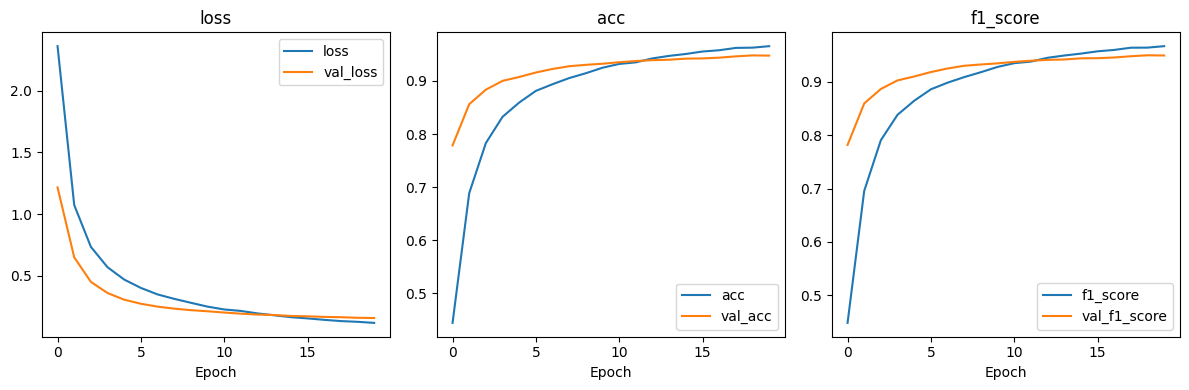

129/129 ━━━━━━━━━━━━━━━━━━━━ 36s 274ms/step - acc: 0.9654 - f1_score: 0.9670 - loss: 0.1192 - precision: 0.9756 - recall: 0.9542 - val_acc: 0.9476 - val_f1_score: 0.9495 - val_loss: 0.1591 - val_precision: 0.9612 - val_recall: 0.9353


NameError: name 'all_dfs' is not defined

In [18]:
from IPython.display import clear_output
records = []
for model in models:
    hist = model.fit(
        train_data,
        epochs=20,
        validation_data=validation_data,
        # steps_per_epoch=155,
        callbacks=[ Call_meback(
            save_weights=False,
            save_metrics=True,
            stop_early=True,
            name=model.name
        ),MetricsPlotter()]
    ).history

    df = pd.DataFrame(hist)

    # add epoch and model columns
    df["epoch"] = df.index + 1
    df["model"] = model.name
    
    records.append(df)



In [36]:
wide_df = pd.concat(records, ignore_index=True)
wide_df


,acc,f1_score,loss,precision,recall,val_acc,val_f1_score,val_loss,val_precision,val_recall,epoch,model
0,0.693388,0.703161,1.017761,0.844847,0.555752,0.864898,0.869105,0.519589,0.951898,0.747143,1,MobileNetV2_head_b_256_d
1,0.765206,0.773803,0.777734,0.875865,0.655438,0.882245,0.885953,0.406243,0.939759,0.811837,2,MobileNetV2_head_b_256_d
2,0.803277,0.811118,0.637951,0.892576,0.718454,0.892653,0.896289,0.349883,0.938608,0.842449,3,MobileNetV2_head_b_256_d
3,0.830902,0.838083,0.547276,0.905339,0.757652,0.900204,0.903613,0.315907,0.940718,0.861429,4,MobileNetV2_head_b_256_d
4,0.847988,0.854917,0.487227,0.911256,0.787805,0.907959,0.911085,0.291800,0.943330,0.873061,5,MobileNetV2_head_b_256_d
...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.955258,0.957333,0.156147,0.969760,0.937654,0.942245,0.944476,0.173041,0.959368,0.930000,16,ResNetv2_head_b_256_d
76,0.957634,0.959943,0.144516,0.971203,0.941949,0.943673,0.945780,0.168518,0.960850,0.931633,17,ResNetv2_head_b_256_d
77,0.962050,0.964110,0.134395,0.974239,0.946822,0.946122,0.948122,0.165709,0.960513,0.933265,18,ResNetv2_head_b_256_d
78,0.962507,0.964281,0.128475,0.973476,0.950142,0.947959,0.949919,0.161077,0.961063,0.936939,19,ResNetv2_head_b_256_d


In [26]:
wide_df.to_csv("all_model_histories.csv", index=False)